In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

from mars.io.nsenwb import NSENWB
from mars.tone import band_response
from scipy.signal import spectrogram
from scipy.signal import gaussian

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

%matplotlib inline

In [2]:
nwb = NSENWB.from_existing_nwb('R32_B8','/Volumes/NSELab/data/rat/NWB/R32/R32_B8.nwb')

In [3]:
raw_stim_dset = nwb.read_mark(name='raw_stimulus')

In [4]:
raw_stim = nwb.index_dset(raw_stim_dset, time_range=[10, 70]).flatten()

In [5]:
bnd_resp = band_response(nwb,
                         proc_name='Wvlt_4to1200_54band_CAR1',
                         device_name='ECoG',
                         device_channels=1 + np.arange(128),
                         time_range=[10, 70],
                         frq_range=[70,170]).T

In [6]:
fs_sound = 96000
fs_ecog = 400
strf_window = 0.125
n_timepoints_window = int(fs_ecog * strf_window)

In [7]:
window_dur = 0.0025
fs = 96000

# set default for step_dur, if unspecified. This value is optimal for Gaussian windows.
step_dur = window_dur / np.sqrt(np.pi) / 8.

# convert window & step durations from seconds to numbers of samples (which is what
# scipy.signal.spectrogram takes as input).
window_nsamp = int(window_dur * fs * 2)
step_nsamp = int(step_dur * fs)

# make the window. A Gaussian filter needs a minimum of 6σ - 1 samples, so working
# backward from window_nsamp we can calculate σ.
window_sigma = (window_nsamp + 1) / 6
window = gaussian(window_nsamp, window_sigma)

# convert step size into number of overlapping samples in adjacent analysis frames
noverlap = window_nsamp - step_nsamp

In [8]:
freq, times, Sxx = spectrogram(raw_stim, detrend=False, mode='psd', fs=fs,
                                      scaling='density', noverlap=noverlap,
                                      window=window, nperseg=window_nsamp)

In [9]:
Sxx_downsample = Sxx[:200, ::15]

In [10]:
Sxx_downsample.shape

(200, 23999)

In [11]:
electrode = 23
responses = bnd_resp[electrode, 1:]

In [12]:
new_times = times[::15]

In [13]:
new_times.shape

(23999,)

In [14]:
Sxx_downsample[:, 0:n_timepoints_window].shape

(200, 50)

In [15]:
n_samples = responses[n_timepoints_window:].size - 1
n_features = Sxx_downsample.shape[0] * n_timepoints_window

In [16]:
X = np.zeros((n_samples, n_features))
y = np.zeros(n_samples)

In [17]:
for sample in range(n_samples):
    base = sample
    end = base + n_timepoints_window
    X[sample] = Sxx_downsample[:, base:end].ravel()
    y[sample] = responses[n_timepoints_window + sample]

In [19]:
ols = LinearRegression()
ols.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [46]:
ols.intercept_

-0.738180025397626

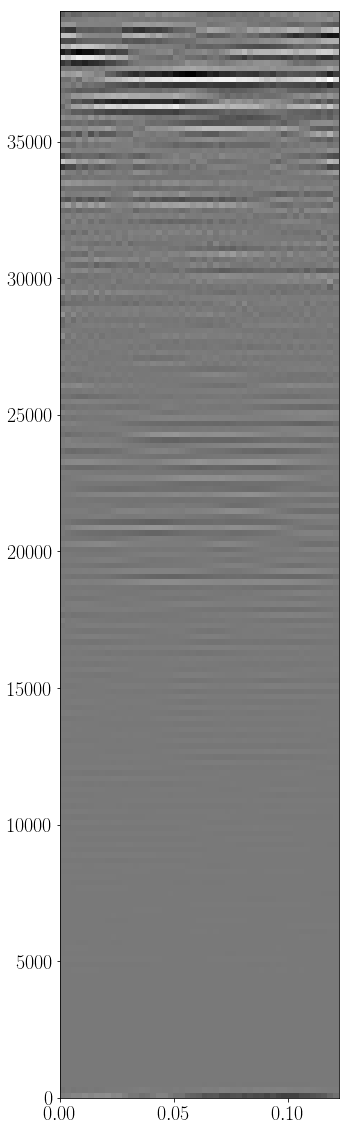

In [42]:
plt.figure(figsize=(5, 20))
ruff = ols.coef_.reshape((200, 50))
pew = np.log(np.abs(ruff))
plt.pcolormesh(np.arange(0, strf_window, 1 / 400), freq[:200], ols.coef_.reshape((200, 50)))

In [45]:
ruff = ols.coef_.reshape((200, 50))
np.abs(ruff)